# North Carolina Voter Registration Analysis (Wake County)

### Requirements
- Download North Carolina voter registration database available here: https://www.ncsbe.gov/results-data/voter-registration-data
- Using the BISG implementation available here
https://surgeo.readthedocs.io/en/dev/
- and the “weighted estimator” as described in this paper
https://arxiv.org/pdf/1811.11154
Task

Write code (in python preferably) to approximate the racial composition of each political party (DEM, REP, LIB, IND) using the weighted estimator and the BISG implementation as your proxy predictor. Do this for a county of your choosing. Also chose some appropriate visualization to show the error of your estimates and the true race proportions

### Some things to keep in mind
- You will need to do a little bit of data processing of the North Carolina voter registration dataset. Make sure that the code you write to do this is well-documented and easy to follow
- I would recommend wrapping the BISG library in a custom class since we will be implementing many other methods for prediction by proxy. Try writing a “ProxyPredictor” interface that contains an “inference” method
- Your subclass’s implementation of the “inference” method should take as input a pandas data frame, and should output a pandas data frame with race predictions
Note: this method will not be complicated for this example, and should just interface the functionality of Surgeo (the BISG library) with the codebase that you are developing

### Download Dataset:


In [1]:
import os

datapath = "data/ncvoter92.txt"
if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.isfile(datapath):
  !wget -O data.zip "https://s3.amazonaws.com/dl.ncsbe.gov/data/ncvoter92.zip"
  !unzip data.zip -d data

zsh:1: command not found: wget
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


## Convert into DataFrame

In [2]:
import pandas as pd
voter_data = pd.read_csv("../"+datapath, sep='\t', encoding="latin1")
print(list(voter_data.columns))
print(voter_data["last_name"].isna().sum()) # TODO: should I remove na last names?
print(voter_data["zip_code"].isna().sum()) # TODO: how does surgeo deal with na zips? should I remove them?
voter_data.head()

['county_id', 'county_desc', 'voter_reg_num', 'ncid', 'last_name', 'first_name', 'middle_name', 'name_suffix_lbl', 'status_cd', 'voter_status_desc', 'reason_cd', 'voter_status_reason_desc', 'res_street_address', 'res_city_desc', 'state_cd', 'zip_code', 'mail_addr1', 'mail_addr2', 'mail_addr3', 'mail_addr4', 'mail_city', 'mail_state', 'mail_zipcode', 'full_phone_number', 'confidential_ind', 'registr_dt', 'race_code', 'ethnic_code', 'party_cd', 'gender_code', 'birth_year', 'age_at_year_end', 'birth_state', 'drivers_lic', 'precinct_abbrv', 'precinct_desc', 'municipality_abbrv', 'municipality_desc', 'ward_abbrv', 'ward_desc', 'cong_dist_abbrv', 'super_court_abbrv', 'judic_dist_abbrv', 'nc_senate_abbrv', 'nc_house_abbrv', 'county_commiss_abbrv', 'county_commiss_desc', 'township_abbrv', 'township_desc', 'school_dist_abbrv', 'school_dist_desc', 'fire_dist_abbrv', 'fire_dist_desc', 'water_dist_abbrv', 'water_dist_desc', 'sewer_dist_abbrv', 'sewer_dist_desc', 'sanit_dist_abbrv', 'sanit_dist_des

,county_id,county_desc,voter_reg_num,ncid,last_name,first_name,middle_name,name_suffix_lbl,status_cd,voter_status_desc,...,sanit_dist_abbrv,sanit_dist_desc,rescue_dist_abbrv,rescue_dist_desc,munic_dist_abbrv,munic_dist_desc,dist_1_abbrv,dist_1_desc,vtd_abbrv,vtd_desc
0,92,WAKE,100228366,EH906352,A,GIM,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,UNC,UNINCORPORATED,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
1,92,WAKE,100790131,EH1299704,A,HMIT,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
2,92,WAKE,100688481,EH1232725,A,MAIH,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
3,92,WAKE,100548507,EH1133682,A,MON,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
4,92,WAKE,100302999,EH962486,A,RUP,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-09,17-09


## Pre Processing:
- Mapping NC races to the BISG races
- Converting zip codes to strings
- removing rows

In [7]:
import numpy as np

print(sorted(voter_data["ethnic_code"].unique()))
print(sorted(voter_data["race_code"].unique()))


# Remove parties other than DEM REP LIB IND
# voter_data = voter_data[voter_data["party_cd"].isin(["DEM", "REP","LIB","UNA"])]
voter_parties = sorted(voter_data["party_cd"].unique())
print(voter_parties)



# Making the "race_code" and "ehnic_code" match with the surgeo's BISG race 
    # hispanic ethnicity takes priority over race
bisg_race = ["white", "black", "api", "native", "multiple", "hispanic"]
race_map = {"A": "multiple",
             "B": "black",
             "P": "api",
             "I": "native",
             "M": "multiple",
             "O": "multiple",
             "U": "multiple",
             "W": "white"}

voter_data["bisg_race"] = voter_data["race_code"].map(race_map)
voter_data.loc[voter_data["ethnic_code"] == "HL", "bisg_race"] = "hispanic"


# Converting zip codes to strings (NAs converted to 0)
voter_data["zip_code"] = voter_data["zip_code"].fillna(0)
voter_data["zip_code"] = voter_data["zip_code"].astype(int).astype(str)


# voter_data["last_name"] = voter_data["last_name"].fillna("")

['HL', 'NL', 'UN']
['A', 'B', 'I', 'M', 'O', 'P', 'U', 'W']
['CST', 'DEM', 'GRE', 'JFA', 'LIB', 'NLB', 'REP', 'UNA', 'WTP']


## Getting proxy race predictions (BISG)

In [8]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from predictors.BISGPredictor_class import BISGPredictor

bisg = BISGPredictor()

sg_results = bisg.inference(voter_data)
sg_results.head(100)

,zcta5,name,white,black,api,native,multiple,hispanic
0,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
1,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
2,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
3,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
4,27610,A,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
95,27613,AARON,0.728965,0.227657,0.011298,0.001653,0.017651,0.012775
96,27526,AARON,0.690820,0.266291,0.002714,0.003134,0.017434,0.019607
97,27545,AARON,0.368671,0.573143,0.003536,0.002737,0.020518,0.031395
98,27610,AARON,0.096610,0.860607,0.002533,0.001299,0.012151,0.026800


### Merge with the voter data with proxy race estimations

In [10]:
merged_voter_data = pd.merge(voter_data, sg_results[bisg_race], left_index = True, right_index=True)[["last_name", "zip_code", "party_cd", "bisg_race", "white", "black", "api", "native", "multiple", "hispanic"]].fillna(0)

## Compute weighted estimator
<img alt="Weighted Estimator Formula" src="images/weighted_estimator_formula.jpg" width = "600">

In [29]:
# Sum of proxy race probabilities for each race
proba_sums = merged_voter_data.loc[:, "white":].sum().to_dict()

# Computes the weighted estimate of the racial composition of each party
estimated_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        race_dist[i] = merged_voter_data.loc[merged_voter_data["party_cd"] == party, race].sum() / proba_sums[race]
    estimated_party_racial_comp[party] = race_dist

estimated_racial_comp = pd.DataFrame(estimated_party_racial_comp, index=bisg_race)

In [30]:
# Number of members of each race group
race_count = {}
for race in bisg_race:
    race_count[race] = len(merged_voter_data[merged_voter_data["bisg_race"] == race])


# Computes the true racial composition of each party
actual_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        race_dist[i] = len(merged_voter_data.loc[(merged_voter_data["party_cd"] == party) & (merged_voter_data["bisg_race"] == race)])/ race_count[race]
    actual_party_racial_comp[party] = race_dist

actual_racial_comp = pd.DataFrame(actual_party_racial_comp, index=bisg_race)
actual_racial_comp

,CST,DEM,GRE,JFA,LIB,NLB,REP,UNA,WTP
white,0.000035,0.259424,0.000477,0.000023,0.008089,0.002035,0.300702,0.429149,0.000065
black,0.000047,0.693336,0.000436,0.000189,0.003195,0.005340,0.025441,0.271792,0.000224
api,0.000000,0.337349,0.024096,0.000000,0.000000,0.024096,0.180723,0.433735,0.000000
native,0.000000,0.359488,0.000426,0.000000,0.007249,0.004691,0.152239,0.475906,0.000000
multiple,0.000034,0.281454,0.000868,0.000050,0.006125,0.004148,0.130418,0.576803,0.000101
hispanic,0.000070,0.365452,0.000953,0.000163,0.007859,0.009580,0.135257,0.480433,0.000233


In [33]:
error = estimated_racial_comp - actual_racial_comp

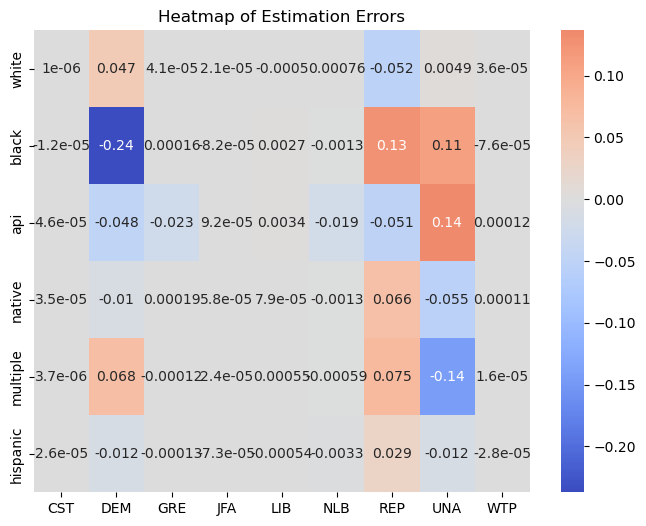

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  
sns.heatmap(error, annot=True, cmap="coolwarm", center = 0) 
plt.title("Heatmap of Estimation Errors")
plt.show()